# Region convolutional neural network (R-CNN)

Four steps [reference](https://towardsdatascience.com/step-by-step-r-cnn-implementation-from-scratch-in-python-e97101ccde55): 
1. Pass the image through selective search and generate region proposal.
2. Calculate IOU (intersection over union) on proposed region with groud truth data and add label to the proposed regions
3. Do transfer learning using the proposed regions with the labels.
4. Pass the test image to selective search and then passe the first 2000 proposed regions from the trained model and predict the class of those regions.

Six steps [reference](https://www.pyimagesearch.com/2020/07/13/r-cnn-object-detection-with-keras-tensorflow-and-deep-learning/):
1. Build object detection dataset with Selective Search
2. Fine-tune classification model on dataset
3. During inference, run Selective Search on input image
4. Make predictions on each proposal using fine-tuned model
5. Apply NMS
6. Return final object detection results

## Data set

The dataset used is the [German Traffic Signs Dataset](https://medium.com/datadriveninvestor/traffic-sign-recognition-using-convolutional-neural-networks-cnn-f7dc5d9d53ba) containing images of shape (32x32x3)



*   The training set has 34799 images
*   The validation set has 4410 images
*   The test set has 12630 images
*   The dataset has **43 unique classes**


**Structure:**
*  One directory per class
*  Each directory container CSV file wit annotations name: GT\<class id \>.csv and the training images
*  training images grouped by tracks (each track has 30 images of one single traffic sign)


**Annotation structure:**
+  CSV with 8 columns
    +  **Filename**
    + **Width**
    + **Height**
    + **x of top left corner**
    + **y of top left corner**
    + **x bottom right corner**
    + **y of bottom right corner**
    + **class id**


We are going to use the same dataset with the [training](https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip) and [test](https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_Images.zip) data in a different format.

You can get the train data [here](https://drive.google.com/file/d/1AZeKw90Cb6GgamTBO3mvDdz6PjBwqCCt/view) with the label values [here](https://www.murtazahassan.com/wp-content/uploads/2020/08/labels.zip)


### **Region of Interest (ROI)**
The region of interest (ROI) are defined in the file gt.txt

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2

### Intersection over Union
[Reference](https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/)

Intersection over Union (IOU) is an **evaluation metric** used to measure the accuracy of an object detetor on a particular dataset. In order to apply IOU to evaluate an (arbitrary) object detector we need:
1. The groundh-trhith bounding boxes (i.e., the hand labeled bounding boxes from the testing set that specify where in the image our object is).
2. The predicted bounding boxes from our model

The IOU can be determined via:
$$ IOU = \frac{Area \; of \; Overlap}{Area \; of \; Union}$$

An IOU score > 0.5 is normally considered a "good" prediction.

In [ ]:
# Function to calculate IOU (Intersection Over Union)

def get_iou(bb1, bb2):
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']    
    
    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])    
    
    if x_right < x_left or y_bottom < y_top:
        return 0.0    
    
    intersection_area = (x_right - x_left) * (y_bottom - y_top)    
    
    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])    
    
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

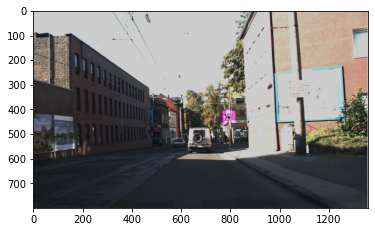

In [31]:
folder = './FullIJCNN2013/00000.ppm'

import cv2
import matplotlib.pyplot as plt
import numpy as np 

image = cv2.imread(folder) # load the image (read in BGR)
line_image = np.zeros_like(image)
cv2.line(line_image, (774,411), (774, 446), (255,0,255), thickness=10)
cv2.line(line_image, (774,411), (815, 411), (255,0,255), thickness=10)
cv2.line(line_image, (774,446), (815, 446), (255,0,255), thickness=10)
cv2.line(line_image, (815,411), (815, 446), (255,0,255), thickness=10)
#plt.imshow(image[...,(2,1,0)])
combo_image = cv2.addWeighted(image[...,(2,1,0)], 0.8, line_image, 1, 1)
plt.imshow(combo_image)
#plt.imshow(line_image)
#plt.show()
#img = cv2.imread('messi5.jpg',0)

#ImgNo#.ppm;#leftCol#;##topRow#;#rightCol#;#bottomRow#;#ClassID#
#774;411;815;446